## Load and prepare data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns

Load data

In [2]:
import pandas as pd

train = pd.read_csv('Data/kaggle_house_train.csv')
test = pd.read_csv('Data/kaggle_house_test.csv')

train.shape,test.shape#test 上了目标变量salespreice

((1460, 81), (1459, 80))

检测oulier,并从原始数据中去除

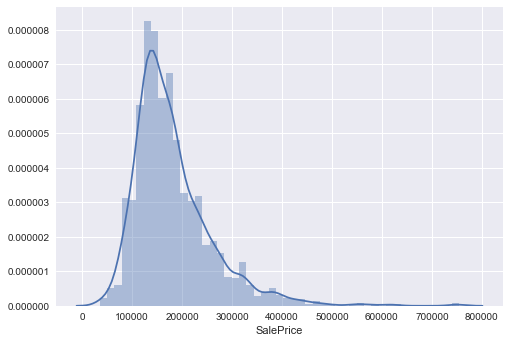

In [3]:
sns.distplot(train.SalePrice)

In [4]:
train.SalePrice.skew() #数据向右侧有一定的偏移

1.8828757597682129

下面我们将zscore的upper_limit作为一个**hyperparameter**(之后可以进行调节)，我们这里姑且把其设为3，如果目标变量SalesPrice大于upperlimit，将被去掉

In [5]:
from scipy.stats import zscore
upper_limit = 3.
np.sum(abs(zscore(train.SalePrice))>upper_limit)

22

In [6]:
train.SalePrice[abs(zscore(train.SalePrice))<upper_limit].skew()

1.0016835845982468

In [7]:
#这里只能对train数据集进行处理
train_y = train.SalePrice[abs(zscore(train.SalePrice))<upper_limit]
train_features = train[abs(zscore(train.SalePrice))<upper_limit].drop(['SalePrice'],axis=1)
#记录训练数据集的长度
train_len = len(train_y)
print(train_len)

test_features = test

1438


In [8]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(2897, 80)

## Deal with NA's

先来看一下变量的整体情况：

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2897 entries, 0 to 2896
Data columns (total 80 columns):
Id               2897 non-null int64
MSSubClass       2897 non-null int64
MSZoning         2893 non-null object
LotFrontage      2413 non-null float64
LotArea          2897 non-null int64
Street           2897 non-null object
Alley            198 non-null object
LotShape         2897 non-null object
LandContour      2897 non-null object
Utilities        2895 non-null object
LotConfig        2897 non-null object
LandSlope        2897 non-null object
Neighborhood     2897 non-null object
Condition1       2897 non-null object
Condition2       2897 non-null object
BldgType         2897 non-null object
HouseStyle       2897 non-null object
OverallQual      2897 non-null int64
OverallCond      2897 non-null int64
YearBuilt        2897 non-null int64
YearRemodAdd     2897 non-null int64
RoofStyle        2897 non-null object
RoofMatl         2897 non-null object
Exterior1st      2896 non-

In [10]:
features.get_dtype_counts()

float64    11
int64      26
object     43
dtype: int64

  把本应为字符型的数值型数据转化为字符型

In [11]:
factors = ['MSSubClass', 'MoSold']

for i in factors:
    features.update(features[i].astype('str'))

  如何处理缺失值，是一个非常困难和麻烦的事情。我这里采用的策略是： 
  对于字符型数据：
  1 直接去掉缺失数大于2000的变量    
  2 对缺失数少于10的变量，我们用mode来进行fillna  
  3 对个别变量例如Garagr 和 basement我们依据数据的具体情况来进行fillna  
  对与数值型数据：  
  1 直接去掉缺失数大于2000的变量   
  2 对缺失数少于10的变量，我们用mean来进行fillna  
  3 对个别变量，如LotFrontage我们几句数据的具体情况进行fillna   

查看带有缺失变量的分布状况：

In [12]:
nulls = np.sum(features.isnull(),axis=0)
nullcols = nulls[nulls!=0]
dtypes = features.dtypes
dtypes2 = dtypes[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
info.columns = ['Nas','Dtype']
print(info)
print("There are", len(nullcols), "columns with missing values")

               Nas    Dtype
PoolQC        2888   object
MiscFeature   2792   object
Alley         2699   object
Fence         2328   object
FireplaceQu   1420   object
LotFrontage    484  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      23   object
MasVnrArea      22  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

In [13]:
Drop_list = ['PoolQC','MiscFeature','Alley','Fence']
features=features.drop(Drop_list,axis=1)

In [14]:
object_cols = features.columns[features.dtypes == 'object']
num_cols = features.columns[features.dtypes != 'object']

less10 = info[info.Nas<10].index
more10 = info[info.Nas>10].index

 对缺失数量小于10的数据进行处理：

In [15]:
#字符型
for i in object_cols & less10:
    features.update(features[i].fillna(features[i].mode()[0]))

In [16]:
#数值型
for i in num_cols & less10:
    features.update(features[i].fillna(features[i].mean()))

这里面需要注意的是，原始数据里有一个2207年间照的房子，很有可能是error，所以改进一下

In [17]:
features[features['GarageYrBlt'] == 2207]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2570,2593,20,RL,68.0,8298,Pave,IR1,HLS,AllPub,Inside,...,0,0,0,0,0,0,9,2007,New,Partial


In [18]:
features.loc[2570,'GarageYrBlt'] = np.int(2007)
features.loc[2570,'GarageYrBlt']

2007.0

一种利用其他变量进行预测缺失值的办法。  
1 对于数值型数据，我们采用回归树进行预测  
2 对于object数据，我们使用决策树来预测  

In [19]:
def model_imputer(data,target_col,model):
    cols = data.columns
    object_cols = data.columns[data.dtypes == 'object']
    num_cols = data.columns[data.dtypes != 'object']
    nonull_index = data[target_col].notnull()
    null_index = data[target_col].isnull()
    for col in cols:
        if col in num_cols:
            data.update(data[col].fillna(data[col].median()))
        else:
            data.update(data[col].fillna(data[col].mode()[0]))
    
    train_y = data[target_col][nonull_index]
    data = data.drop([target_col],axis=1)
    data = pd.get_dummies(data)
    train_x = data[nonull_index]
    test_x = data[null_index]
    fit = model.fit(train_x,train_y)
    predictions = fit.predict(test_x)
    return predictions
    

In [20]:
more10 = info[info.Nas>10].index
num_cols & more10

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [21]:
features['LotFrontage'].isnull().any()

True

In [22]:
from sklearn.tree import DecisionTreeRegressor
col = 'LotFrontage'
predictions = model_imputer(data=features.copy(),target_col=col,model=DecisionTreeRegressor())
features.loc[features[col].isnull(),col] = predictions


In [23]:
features['LotFrontage'].isnull().any()

False

In [24]:
features['MasVnrArea'].isnull().any()

True

In [25]:
col = 'MasVnrArea'
predictions = model_imputer(features.copy(),target_col=col,model=DecisionTreeRegressor())
features.loc[features[col].isnull(),col] = predictions

In [26]:
features['MasVnrArea'].isnull().any()

False

In [27]:
features['GarageYrBlt'].isnull().any()

True

In [28]:
from sklearn.tree import DecisionTreeRegressor
col = 'GarageYrBlt'
predictions = model_imputer(features.copy(),target_col=col,model=DecisionTreeRegressor())
features.loc[features[col].isnull(),col] = predictions

In [29]:
object_cols & more10

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [30]:
from sklearn.tree import DecisionTreeClassifier

for col in object_cols & more10:
    predictions = model_imputer(features.copy(),target_col=col,model=DecisionTreeClassifier())
    features.loc[features[col].isnull(),col] = predictions
    

In [31]:
features['GarageCond'].value_counts()

TA    2740
Fa     121
Gd      18
Po      15
Ex       3
Name: GarageCond, dtype: int64

In [32]:
factors = object_cols & more10

for i in factors:
    features.update(features[i].astype('str'))

检查一下其他变量的情况

In [33]:
na_info = []
for col in object_cols & more10:
    na_info.append(features[col].isnull().any()) 

In [34]:
na_info

[False, False, False, False, False, False, False, False, False, False, False]

In [35]:
#现在我们再来check 一下所有数据
np.sum(features.notnull().all(axis=0)) == features.shape[1]
#所有数据都不存在NA

True

In [36]:
features.shape #需要注意的是id在训练时需要去掉，在最后输出结果时又要保留

(2897, 76)

## Skew transformation features

In [37]:
from scipy.stats import skew
skew_features = features[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.864303
PoolArea,17.720489
LotArea,13.081311
LowQualFinSF,12.368644
3SsnPorch,11.332155
KitchenAbvGr,4.283471
BsmtFinSF2,4.140580
EnclosedPorch,4.002583
ScreenPorch,3.955254
BsmtHalfBath,3.928186


In [38]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))

        
skew_features2 = features[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

/Users/jiangchaodi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,skew
PoolArea,15.545437
3SsnPorch,8.830990
LowQualFinSF,8.574193
MiscVal,5.218826
BsmtHalfBath,3.767628
KitchenAbvGr,3.762703
ScreenPorch,3.168595
BsmtFinSF2,2.566755
EnclosedPorch,2.145596
MasVnrArea,0.983173


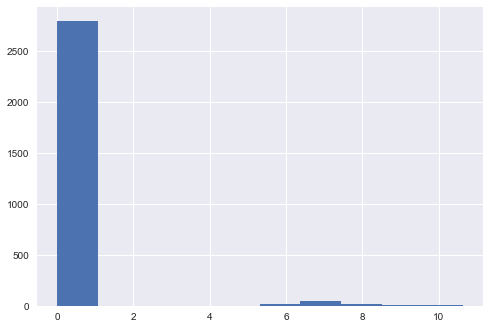

In [39]:
features['MiscVal'].hist()

针对字符型变量，查看并去除一些数值倾斜比较大的变量，比如莫个类别占比97%以上。

In [40]:
sums_features = features[object_cols].apply(lambda x: len(np.unique(x)))
sums_features.sort_values(ascending=False)

Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
MoSold           12
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
RoofStyle         6
BsmtFinType1      6
SaleCondition     6
Heating           6
GarageType        6
Foundation        6
BldgType          5
GarageQual        5
MSZoning          5
ExterCond         5
Electrical        5
LotConfig         5
FireplaceQu       5
GarageCond        5
HeatingQC         5
LotShape          4
LandContour       4
BsmtCond          4
BsmtQual          4
BsmtExposure      4
KitchenQual       4
MasVnrType        4
ExterQual         4
PavedDrive        3
LandSlope         3
GarageFinish      3
Utilities         2
Street            2
CentralAir        2
dtype: int64

我们来查看一下变量数比较少

In [42]:
print(features['Street'].value_counts())
print('-----')
print(features['Utilities'].value_counts())
print('-----')
print(features['CentralAir'].value_counts())
print('-----')
print(features['PavedDrive'].value_counts())

Pave    2885
Grvl      12
Name: Street, dtype: int64
-----
AllPub    2896
NoSeWa       1
Name: Utilities, dtype: int64
-----
Y    2701
N     196
Name: CentralAir, dtype: int64
-----
Y    2619
N     216
P      62
Name: PavedDrive, dtype: int64


In [43]:
features = features.drop(['Utilities', 'Street'], axis=1)

In [44]:
features.shape

(2897, 74)

In [45]:
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])


#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [47]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2897, 306)

为了减少overfitting的影响，我们设置第二个超参数**dummy_cut**来控制比例过高的变量

In [66]:
dummy_cut = 0.995
overfit = []
for i in final_features.columns:
    counts = final_features[i].value_counts()  #count 它是降序排列的
    first_count = counts.iloc[0]   
    if first_count / len(final_features) >dummy_cut:
        overfit.append(i)

In [67]:
overfit

['PoolArea',
 'haspool',
 'MSSubClass_150',
 'MSSubClass_40',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_CBlock',
 'Exterior2nd_ImStucc',
 'Exterior2nd_Other',
 'Exterior2nd_Stone',
 'ExterCond_Ex',
 'ExterCond_Po',
 'Foundation_Stone',
 'Foundation_Wood',
 'BsmtCond_Po',
 'Heating_Floor',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'HeatingQC_Po',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Functional_Maj2',
 'Functional_Sev',
 'GarageQual_Ex',
 'GarageQual_Po',
 'Ga

In [68]:
final_features.drop(overfit,axis=1,inplace=True)

In [69]:
final_features.shape

(2897, 249)

这里我们使用train_len来获取最后的train_set

In [73]:
X = final_features.iloc[:train_len,:]
test_X = final_features.iloc[train_len:,:]

In [74]:
X.shape,test_X.shape

((1438, 249), (1459, 249))

In [76]:
train_y.shape

(1438,)

把数据保存起来

In [77]:
X.to_csv('./Data/houseprice/X.csv')
train_y.to_csv('./Data/houseprice/train_y.csv')
test_X.to_csv('./Data/houseprice/test_X.csv')
